N tiles: 12
Tile: tile_019_y576_x768_C4.tif
CYX: (4, 256, 256) float32


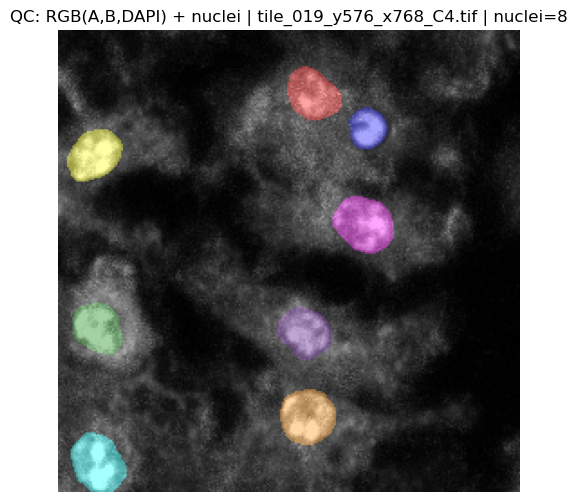

In [3]:
# --- Single-cell test cell: load one tile -> tune nucleus segmentation -> QC overlay ---

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.config import PipelineConfig
from src.io_utils import list_toy_tiles, read_multichannel_tif
from src.preprocess import apply_gamma, smooth
from src.segmentation import segment_nuclei, count_nuclei
from src.viz import make_rgb, overlay_nuclei_on_rgb

cfg = PipelineConfig()

# -----------------------------
# 0) Choose tile
# -----------------------------
tiles = list_toy_tiles(cfg.paths.toy_images_dir)
if len(tiles) == 0:
    raise FileNotFoundError(f"No tiles found under: {cfg.paths.toy_images_dir}")
print("N tiles:", len(tiles))

tile_idx = 0  # <<< change this to pick another tile
tile_path = Path(tiles[int(tile_idx)])
cyx = read_multichannel_tif(tile_path).astype(np.float32)
print("Tile:", tile_path.name)
print("CYX:", cyx.shape, cyx.dtype)

# -----------------------------
# 1) Manual tuning area
# -----------------------------
# Preview RGB (R,G,B) for QC (A,B,DAPI)
cfg.preview.rgb_channels = (1, 2, 0)

# Preprocess
cfg.preprocess.apply_gamma = True
cfg.preprocess.gamma = 0.85
cfg.preprocess.gaussian_sigma = 1.0

# Nucleus segmentation
cfg.nucleus.dapi_channel = 0
cfg.nucleus.threshold_method = "otsu"      # "otsu" or "percentile"
cfg.nucleus.percentile = 99.3             # used if percentile
cfg.nucleus.min_area = 200
cfg.nucleus.max_area = None
cfg.nucleus.closing_radius = 2
cfg.nucleus.opening_radius = 1
cfg.nucleus.split_touching = True
cfg.nucleus.min_peak_distance = 8
cfg.nucleus.distance_transform_sigma = 1.0

# -----------------------------
# 2) Segment nuclei
# -----------------------------
dapi = cyx[cfg.nucleus.dapi_channel]
x = dapi
if cfg.preprocess.apply_gamma:
    x = apply_gamma(x, cfg.preprocess.gamma)
x = smooth(x, cfg.preprocess.gaussian_sigma)

nuc_labels = segment_nuclei(
    x,
    threshold_method=cfg.nucleus.threshold_method,
    percentile=cfg.nucleus.percentile,
    min_area=cfg.nucleus.min_area,
    max_area=cfg.nucleus.max_area,
    closing_radius=cfg.nucleus.closing_radius,
    opening_radius=cfg.nucleus.opening_radius,
    split_touching=cfg.nucleus.split_touching,
    distance_transform_sigma=cfg.nucleus.distance_transform_sigma,
    min_peak_distance=cfg.nucleus.min_peak_distance,
).astype(np.int32)

n = count_nuclei(nuc_labels)

# -----------------------------
# 3) QC overlay
# -----------------------------
rgb = make_rgb(cyx, cfg.preview.rgb_channels)
ov = overlay_nuclei_on_rgb(rgb, nuc_labels, alpha=0.35)

plt.figure(figsize=(6, 6))
plt.title(f"QC: RGB(A,B,DAPI) + nuclei | {tile_path.name} | nuclei={n}")
plt.imshow(ov)
plt.axis("off")
plt.show()
